In [1]:
%autosave 1

Autosaving every 1 seconds


# Heteroplasmies in RNA-seq

> This IPython notebook replicates the analyses shown in Rebolledo-Jaramillo, Su,  et al (2014) *Maternal Age Effect and Severe Germline bottleneck in the Inheritance of mitochondrial DNA heteroplasmy*  [**PNAS October 28, 2014 vol. 111 no. 43 15474-15479**](http://www.pnas.org/content/111/43/15474.abstract)

> - One individual, multiple tissues


> - After all samples are processed throught the alignment and filtering workflow, the final file contains allele counts for all samples at each of the 16,569 positions in the mitochondrial genome. That is 364,518 lines to process.


> - We will use a combination of Python and R scripts to replicate the results shown in the PNAS publication.

# Import necessary python modules

Module |  Description
-------|-------------
[pandas](http://pandas.pydata.org/) | Library providing high-performance, easy-to-use data structures and data analysis tools 
[numpy](http://www.numpy.org/) | Package for scientific computing with Python
[itertools](https://docs.python.org/2/library/itertools.html) | Functions creating iterators for efficient looping

In [2]:
import pandas as pd
import numpy as np
import itertools

# Get input data from the history. 
><i class="icon-pencil"> In this case, the allele counts are located in history item 1. To access it use "get(1)". </i>

><i class="icon-exclamation"> You need to adjust the history item to your own case when needed.

In [3]:
tissue = "blood"

allelecounts="GTEX-"+tissue+".counts"
sampleDetails="GTEX-"+tissue+".info"
kallisto="GTEX-"+tissue+".tpm"
bias="GTEX-"+tissue+".bias"

sampleName = allelecounts.split(".")[0].split("-")[1]
hq_out = "%s_hq_sites.txt" % sampleName
annotated_out = "%s_annotated_hq_sites.txt" % sampleName

><i class="icon-pencil"> Pandas can read tabular data directly into a dataframe. We will look at the first line of the data to identify a potential header line, and add the option accordingly to the pandas "read_table" method. 

In [4]:
with open(allelecounts) as ac:
    first_line = ac.readline()
    if first_line.startswith("#"):
        df = pd.read_table(allelecounts)
    else:
        df = pd.read_table(allelecounts,header=None)

# Prepare data
><i class="icon-pencil"> If a header is present, Pandas will assign the column names automatically, however we will standardize the column names to ease access later .

In [5]:
df.columns=["sample","reference","position","A","C","G","T","a","c","g","t","cvrg","nalleles","major","minor","maf"]

><i class="icon-pencil">  Let's take a look at the first two lines in the data frame

In [6]:
sampleNames = pd.read_table(sampleDetails,header=None)

In [7]:
old = list(sampleNames.loc[:,1])
new = list(sampleNames.loc[:,2])
new2 = ["%s_%s" % t for t in zip(new,old)]
df.replace(to_replace=old,value=new2,inplace=True)

In [8]:
df.head()

sample reference  position   A   C   G   T  a  c  g  t  \
0  Whole Blood_SRR1069024      chrM         1   0   0  41   0  0  0  3  0   
1  Whole Blood_SRR1069024      chrM         2  40   0   0   0  3  0  0  0   
2  Whole Blood_SRR1069024      chrM         3   0   0   0  42  0  0  0  3   
3  Whole Blood_SRR1069024      chrM         4   0  44   0   0  0  3  0  0   
4  Whole Blood_SRR1069024      chrM         5  44   0   0   0  3  0  0  0   

   cvrg  nalleles major minor  maf  
0    44         1     G     .    0  
1    43         1     A     .    0  
2    45         1     T     .    0  
3    47         1     C     .    0  
4    47         1     A     .    0

# Figure: samples sequencing depth distribution

><i class="icon-pencil">At this point we can calculate the coverage distribution of each sample, as shown in Figure S7 in the PNAS paper.</i>

>To do so, we need to make the df object available to R (via [Rpy2](http://rpy.sourceforge.net/)).


><i class="icon-pencil"> [Rmagic](http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html#module-rpy2.ipython.rmagic) is an extension of IPython designed to run R code. </i>

><i class="icon-exclamation"> Rmagic needs to be loaded before any work with R code can be done.</i>

In [9]:
%load_ext rpy2.ipython

><i class="icon-exclamation"> Rmagic usage specifics: </i>

One line R code |  Block of R code
----------------|-----------------
%R|%%R


><i class="icon-pencil"> Python objects are passed onto R (as data frames with headers) with the **-i** flag</i>

In [10]:
%R -i df

><i class="icon-pencil"> Transform numeric looking columns into actual numeric columns to guarantee the value types</i>

In [11]:
%%R
tonumeric = c(3:13,16)
df[,tonumeric] = apply(df[,tonumeric], 2, function(x) as.numeric(as.character(x)))


><i class="icon-pencil"> Define custom R function to generate coverage figure</i>

In [12]:
%%R
boxPlotCvrg = function(data,tissue){
    
    #names = sort(unique(data[["sample"]]))
    #data[["sample"]] = factor(data[["sample"]],levels=names)
    
    meds = aggregate(data$cvrg, by=list(data$sample),FUN=median)
    ordered = as.character(meds[order(-meds$x),]$Group.1)

    
    data[["sample"]] = factor(data[["sample"]],levels=ordered)
    MIN = floor(min(log10(data$cvrg+1)))
    MAX = ceiling(max(log10(data$cvrg+1)))
    

    boxplot(log10(cvrg)~sample,data=data,whisklty="solid",outcol=rgb(255,99,71,50,maxColorValue=255),pch=16,
            whisklwd=2,boxlwd=1,medlwd=1,medcol="black",main="",
            xlab=expression(paste("log"[10],"(coverage)",sep="")),bty="n",frame=F,boxcol="black",
            boxfill="azure3",medlwd=4,whiskcol="grey",staplecol="grey",ylim=c(MIN,MAX),
            cex.axis=1,horizontal=TRUE,xaxt="n",cex.lab=2)
    
    mtext(tissue,adj=0,side=3,las=1,at=(MAX+1)/2,font=2,cex=2)
    axis(1,at=MIN:MAX,cex.axis=2,las=1)
    }

### Plot
><i class="icon-pencil"> You can adjust the size of the plotting image by adjusting:</i>

width|height|units|resolution
-----|------|-----|----------
-w|-h|-u|-r

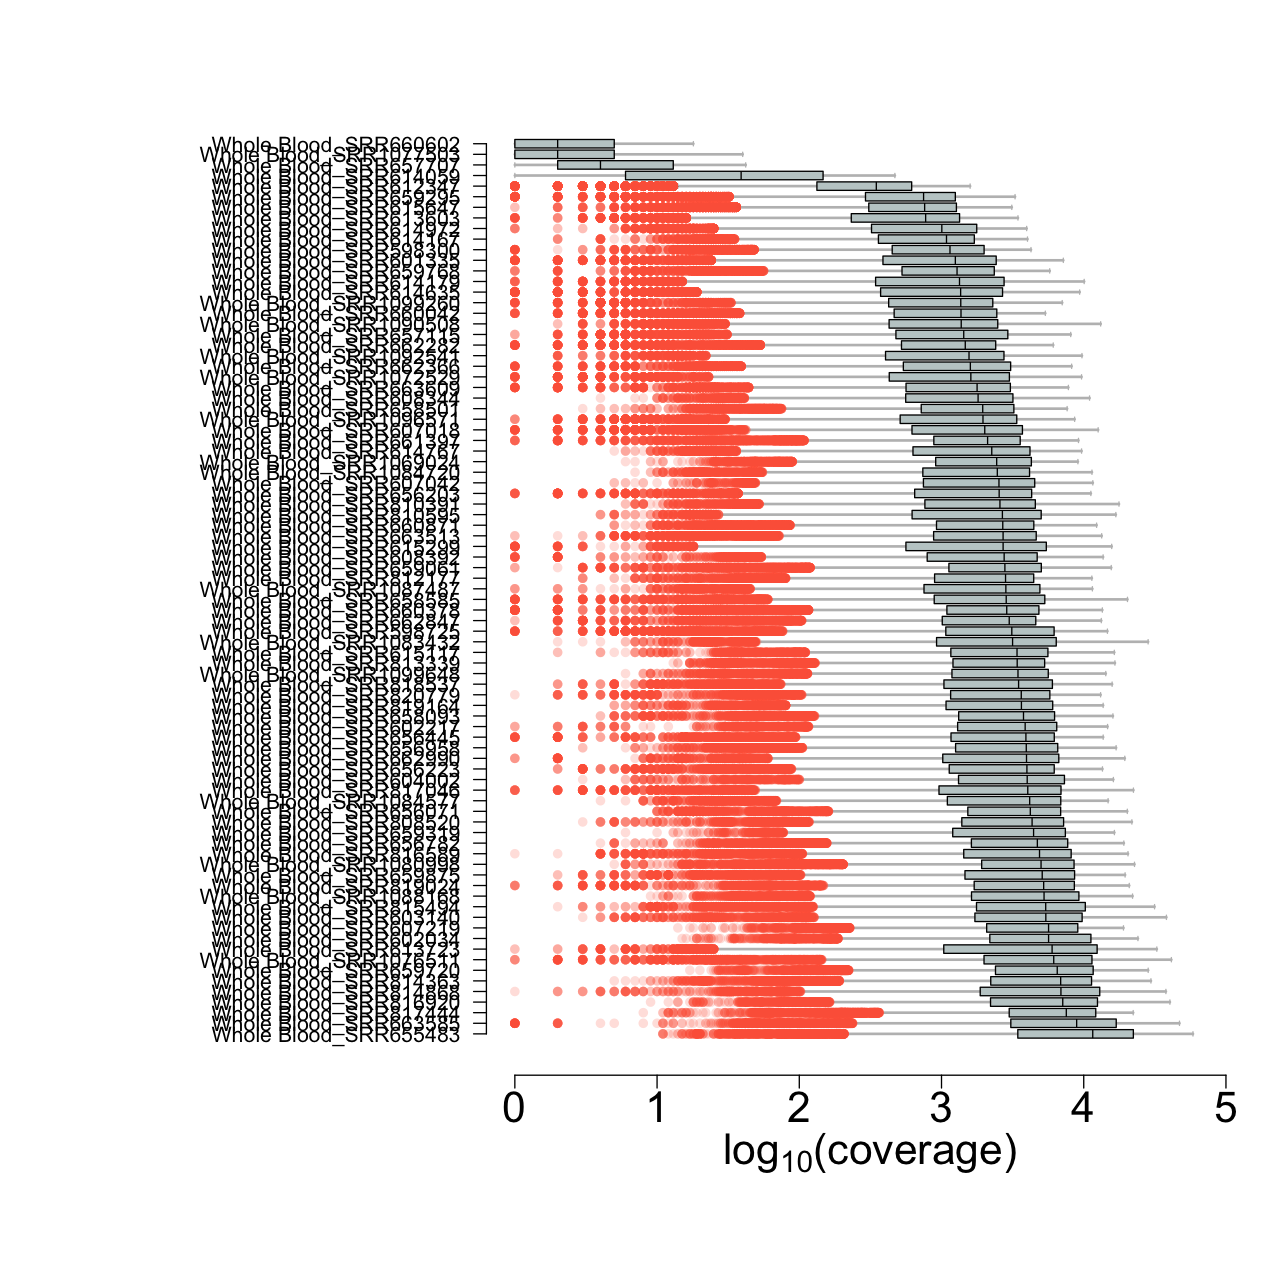

In [13]:
%%R -w 10 -h 10 -u in -r 128

par(las=2)
par(mar=c(6,17,4,1))
par(oma=c(2,2,0,0))
#par(mfrow=c(2,1))
#par(cex.lab=1.25)
#par(cex.axis=0.75)

boxPlotCvrg(df,"")


In [14]:
%%R

# average median coverage of samples
bp = boxplot(cvrg~sample,data=df,plot=FALSE)
stats = cbind(bp$n,bp$stats[3,])
Nsamples = nrow(stats)
meanSites = floor(mean(stats[,1]))
meanCvrg = floor(mean(stats[,2]))
cbind(c("Nsamples","Nsites","Cvrg"),c(Nsamples,meanSites,meanCvrg))

     [,1]       [,2]   
[1,] "Nsamples" "85"   
[2,] "Nsites"   "15957"
[3,] "Cvrg"     "3246" 


# Identification of high quality heteroplasmic sites

 ><i class="icon-pencil"> We defined high quality (HQ):</i>
 
 >1. minor allele frequency (maf) ≥ 1%
 >2. coverage ≥ 1000
 >3. maf balance (1% in forward and reverse strands)
 >4. no strand bias
 >5. outside "problematic sites":
     - mtDNA homopolymeres
     - around the artificial "N" at position 3107
     - within 50 bp of the long range PCR primers


><i class="icon-pencil"> Back in Python, we define the "problematic sites" ranges...</i>

In [15]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

In [16]:
rCRS = SeqIO.read(open("/Users/boris/GoogleDrive/Genomes/rCRS.gb","r"), "genbank")
genedb = dict()
labs = ["class","start","end","strand"]
for feature in rCRS.features:
    if feature.type in ["rRNA","tRNA","CDS"]:
        ftype = feature.type
        name = feature.qualifiers['gene'][0]
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = int(feature.location.strand)
        genedb[name] = dict(zip(labs,[ftype,start,end,strand]))
genedb['D-loop1'] = dict(zip(labs,["Dloop",0,576,1]))
genedb['D-loop2'] = dict(zip(labs,["Dloop",16023,16569,1]))

In [17]:
#mask_trna = []
#annotated = []
#for region in genedb:
#    start = genedb[region]['start']
#    end = genedb[region]['end']
#    annotated+=range(start,end)
#    
#    if genedb[region]['class']=="tRNA":
#        mask_trna+=range(start,end)
#        
#noncoding = [i for i in range(16569) if i not in annotated]
#mask2 = mask_trna+noncoding


In [18]:
coding_rrna = []
for region in genedb:
    start = genedb[region]['start']
    end = genedb[region]['end']
    
    if genedb[region]['class'] in ["rRNA","CDS"]:
        coding_rrna+=range(start,end)

><i class="icon-pencil"> ... and filter the main dataframe **partially** on maf, coverage and position</i>

In [19]:
hq_sites = df[(df.maf>=0.01) & (df.cvrg>=1000) & df.position.isin(coding_rrna)]

In [20]:
len(hq_sites)

3901

><i class="icon-pencil"> By applying these initial filters, we reduced the dataframe from ~300,000 lines to 572 lines only, which is much more manageable.</i>


> <i class="icon-pencil"> Next, we calculate strand bias and maf balance on these 572 sites... </i>


In [21]:
def strand_stats(x, mafThreshold=0.01):
    falleles = ['A','C','G','T']
    ralleles = ['a','c','g','t']
    sample,position,major,minor,coverage,maf = x[['sample','position','major','minor','coverage','maf']]
    fcounts = x[falleles]
    rcounts = x[ralleles]
    if minor!='.':
        index_major = falleles.index(major)
        index_minor = falleles.index(minor)

        fcount_minor = float(fcounts[index_minor])
        ftotal = fcount_minor + fcounts[index_major]
        
        rcount_minor = float(rcounts[index_minor])
        rtotal = rcount_minor + rcounts[index_major]
        
        minor_total = float(fcount_minor + rcount_minor)
        site_total = ftotal + rtotal

        try:
            strandBias = abs( (fcount_minor/ftotal) - (rcount_minor/rtotal) ) / (minor_total/site_total)
        except:
            strandBias = np.nan
            
        try:
            maf_frwd = fcount_minor/sum(fcounts)
        except:
            maf_frwd = np.nan
        try:
            maf_rvrs = rcount_minor/sum(rcounts)
        except:
            maf_rvrs = np.nan
            
        if (maf_frwd>=mafThreshold) and (maf_rvrs>=mafThreshold):
            mafBalance = 1
        else:
            mafBalance = 0
    else:
        strandBias = float(2)
        mafBalance = 0

    return pd.Series([strandBias,mafBalance])

In [22]:
biasCols = hq_sites.apply(strand_stats,axis=1,args=(0.01,))
biasCols.columns = ["strandBias","mafBalance"]
hq_sites = pd.concat([hq_sites,biasCols],axis=1)

> <i class="icon-pencil">... and filter them on maf balance and strand bias 

In [23]:
hq_sites = hq_sites[(hq_sites.strandBias<=1) & (hq_sites.mafBalance==1) ]
len(hq_sites)

763

In [24]:
from scipy.stats import poisson

In [25]:
def poisson_pval(current_df,sample):
    alleles = ['A','C','G','T','a','c','g','t']
    current_counts = list(current_df.loc[current_df['sample']==sample, alleles].iloc[0,:])
    others_counts = list(current_df.loc[current_df['sample']!=sample, alleles].apply(sum,axis=0))
    site_error = (sum(others_counts) - max(others_counts))/float(sum(others_counts))
    current_nonMajor_counts = int(sum(current_counts)-max(current_counts))
    current_coverage = sum(current_counts)
    pvalue = poisson.pmf(current_nonMajor_counts, site_error*current_coverage)
    return pvalue

In [26]:
poisson_pvalues = []

for s,p in hq_sites[["sample","position"]].itertuples(index=False):
    poisson_pvalues.append(poisson_pval(df[df['position']==p],s))


In [27]:
hq_sites["poisson"]=poisson_pvalues
hq_sites = hq_sites[hq_sites.poisson<=0.05]
len(hq_sites)

763

> <i class=icon-exclamation> There is an additional screenning step not shown here, where we calculate the cycle bias of the site, i.e. whether the alternative allele is supported primarily by nucleotides within 25 bp of the read ends. </i> 


# Screening for contamination
> In our previous publication, Dickins, Rebolledo-Jaramillo, et al (2014) Controlling for contamination in resequencing studies with a reproducible web-based phylogentic approach [BioTechniques, 56(3):134–141](http://goo.gl/jv2J34), we described signs of potential contamination:
 1. Many heteroplasmic sites (≥5 per sample)
 2. Tigh minor allele frequency distribution
 3. Non-family related positions
 
> <i class="icon-pencil"> We routinely apply our contamination detection pipeline, so we are confident our sites in the PNAS paper were not artifacts. As an example of the screening for contamination, we can plot the number of sites and the minor allele frequency distribution of all samples in the high quality sites set

In [28]:
# Make R aware of the hq_sites dataframe
%R -i hq_sites

In [29]:
%%R

# Adjust value types in the hq_sites dataframe

tonumeric = c(3:13,16:18)
hq_sites[,tonumeric] = apply(hq_sites[,tonumeric], 2, function(x) as.numeric(as.character(x)))
#head(hq_sites,2)

In [30]:
%%R

meds = aggregate(hq_sites$maf, by=list(hq_sites$sample),FUN=function(x) length(x))
ordered = as.character(meds[order(-meds$x),]$Group.1)
hq_sites$sample = factor(hq_sites$sample,levels=ordered)


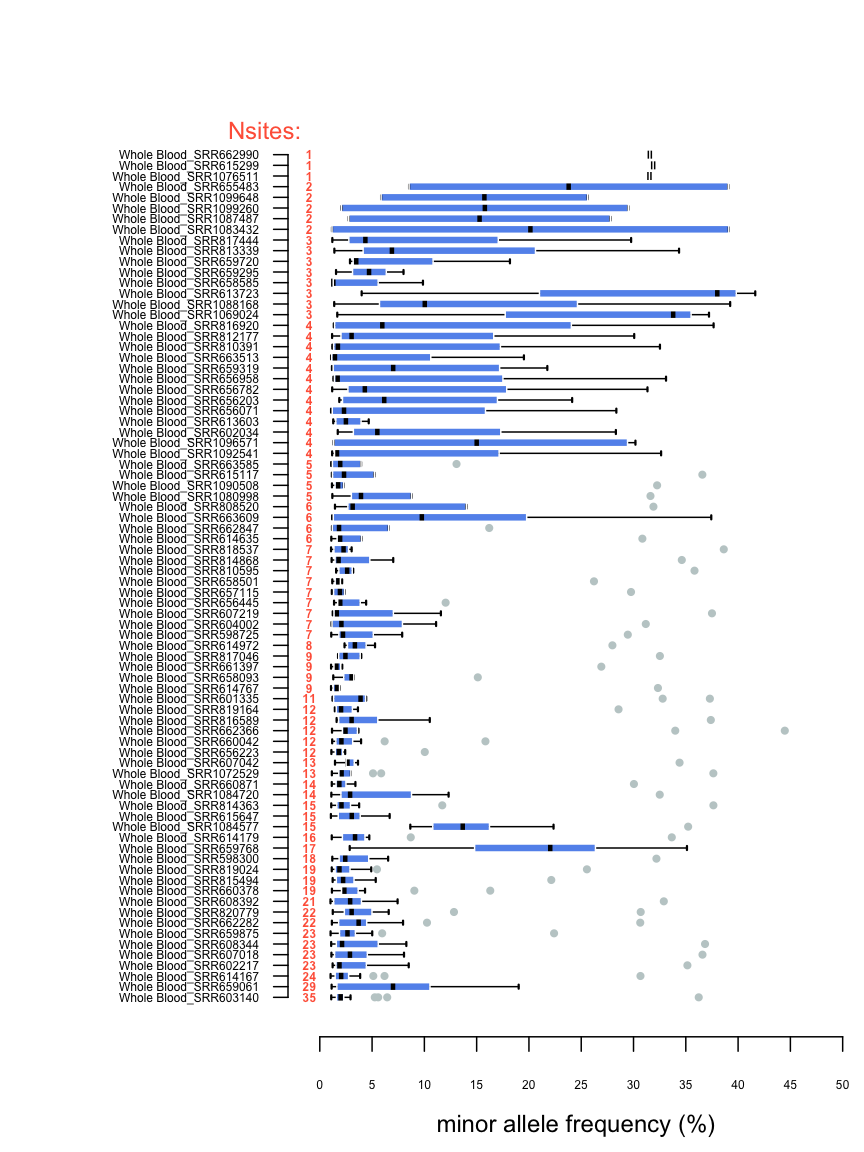

In [31]:
%%R -w 6 -h 8 -u in -r 144

# Plot hq_sites number of sites and minor allele frequency distribution

sortedSample = names(sort(apply(hq_sites,2,median)))

par(mar=c(4,10,4,0))
boxplot(
  maf~sample,
  data=hq_sites,
  pch=16,cex=0.75,
  outcol="azure3",outline=T,
  whisklty=1,whiskwd=1.5,
  staplelwd=1.5,
  boxwex=0.75,boxcol="white",boxfill="cornflowerblue",
  horizontal=T,cex.axis=0.5,las=2,
  frame=F,xaxt="n",ylim=c(-0.01,0.5)
  )

axis(1,at=seq(0,5,0.5)/10,lab=100*(seq(0,5,0.5)/10),cex.axis=0.5)
title(xlab="minor allele frequency (%)",line=2.5,cex.axis=0.75)

nsites = table(hq_sites[["sample"]])
for (i in 1:length(nsites)){
  text(-0.01,i,lab=nsites[i],cex=0.5,font=2,col="tomato")
}
mtext("Nsites:",side=3,line=-1,at=0,adj=1.25,col="tomato")

# Tabulating high quality sites

> <i class="icon-pencil"> For each high quality site, we can retrieve the minor allele frequency information for the remaining samples in the collection. </i>

In [32]:
unique_positions = hq_sites["position"].drop_duplicates()
len(unique_positions)

294

In [33]:
hq_sites.to_csv(hq_out,sep="\t")

In [34]:
from collections import Counter

In [35]:
# tabulate minor allele frequencies for all tissues per position, where at least one of the tissues showed a
# high quality heteroplasmy

tissues = list(df['sample'].drop_duplicates())
columns = ["position","major","minor"]+tissues
heatmap = pd.DataFrame(index=range(len(unique_positions)),columns=(range(len(columns))))
i=-1

for p in unique_positions:
    i+=1
    current = df[df.position==p].loc[:,['sample','position','major','minor','maf']]
    #current2 = current.loc[(current.maf>=0.01)]
    alleles = zip(current.major,current.minor)
    ref = Counter(alleles).most_common()[0][0]

    MAFS=[]
    #for sample in current.iterrows():
    #    tissue,pos,major,minor,maf = list(sample[-1])
    for t in tissues:
        try:
            tissue,pos,major,minor,maf = list(current.loc[current["sample"]==t,].squeeze())
        except:
            tissue,pos,major,minor,maf = [sample,p,".",".","."]
             
        
        if (major,minor) == ref:
            MAF = maf
            
            
        elif (major,minor) == ref[::-1]:
            MAF = 1 - float(maf)
            
            
        else:
            MAF = 'NA'
           
        MAFS.append(MAF)
    
    heatmap.loc[i] = [p]+list(ref)+MAFS

heatmap.columns = columns


In [36]:
heatmap = heatmap[(heatmap.minor!=".")]

In [37]:
%R -i heatmap

In [38]:
%%R
require("gplots")

/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: gplots

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘gplots’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:stats’:

    lowess


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [39]:
%%R
myPalette=colorRampPalette(c("white","cornflowerblue","tomato"))

tmpData = heatmap[,4:ncol(heatmap)]
tmpData = apply(tmpData,2, FUN=function(x) as.numeric(x)*100)
rownames(tmpData)=heatmap$position
tmpData = tmpData[order(as.numeric(rownames(tmpData))),order(as.character(colnames(tmpData)))]
    
    
tmpData2 = apply(tmpData,2, sprintf,fmt="%.2f")
tmpData2[as.numeric(tmpData2)<0.005*100] = ""

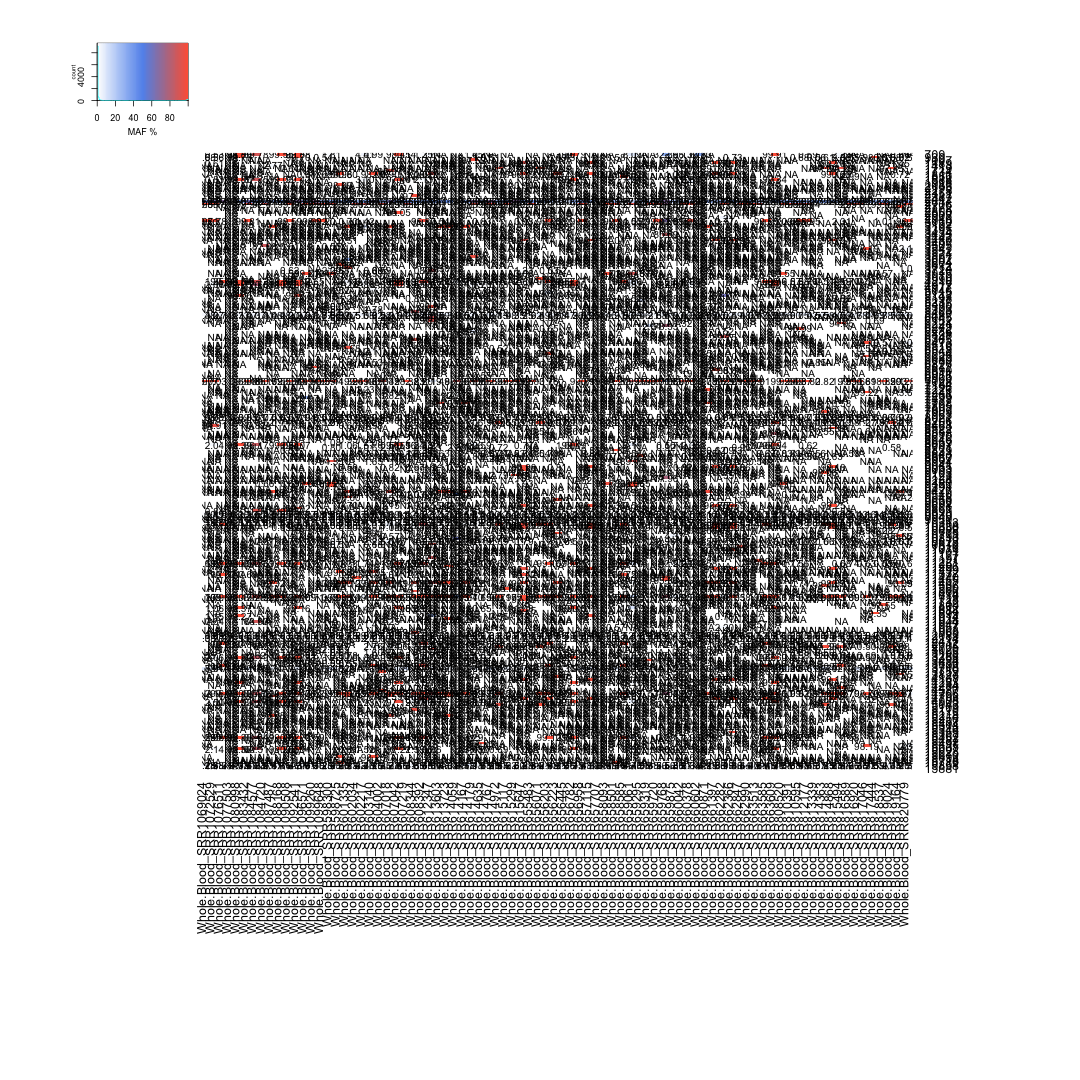

In [40]:
%%R -w 15 -h 15 -u in -r 72
par(oma=c(20,5,2,10))

heatmap.2(tmpData,
          dendrogram="none",
          Colv=F,
          Rowv=F,
          breaks=seq(0*100,1*100,0.01*100),
          trace="none",
          col=myPalette,
          keysize=0.75,
          key.title="",
          key.xlab="MAF %",
          key.ylab="count",
          key.par=list(cex.axis=1),
          margins=c(6,4),
          cexCol=1.25,
          cexRow=1.25,
          cellnote=tmpData2,
          notecol='black',
          notecex=1,
          sepwidth=c(0.01,0.01),
          #rowsep=1:length(uniqPos),
          sepcol="gold",
          #colsep=14
)

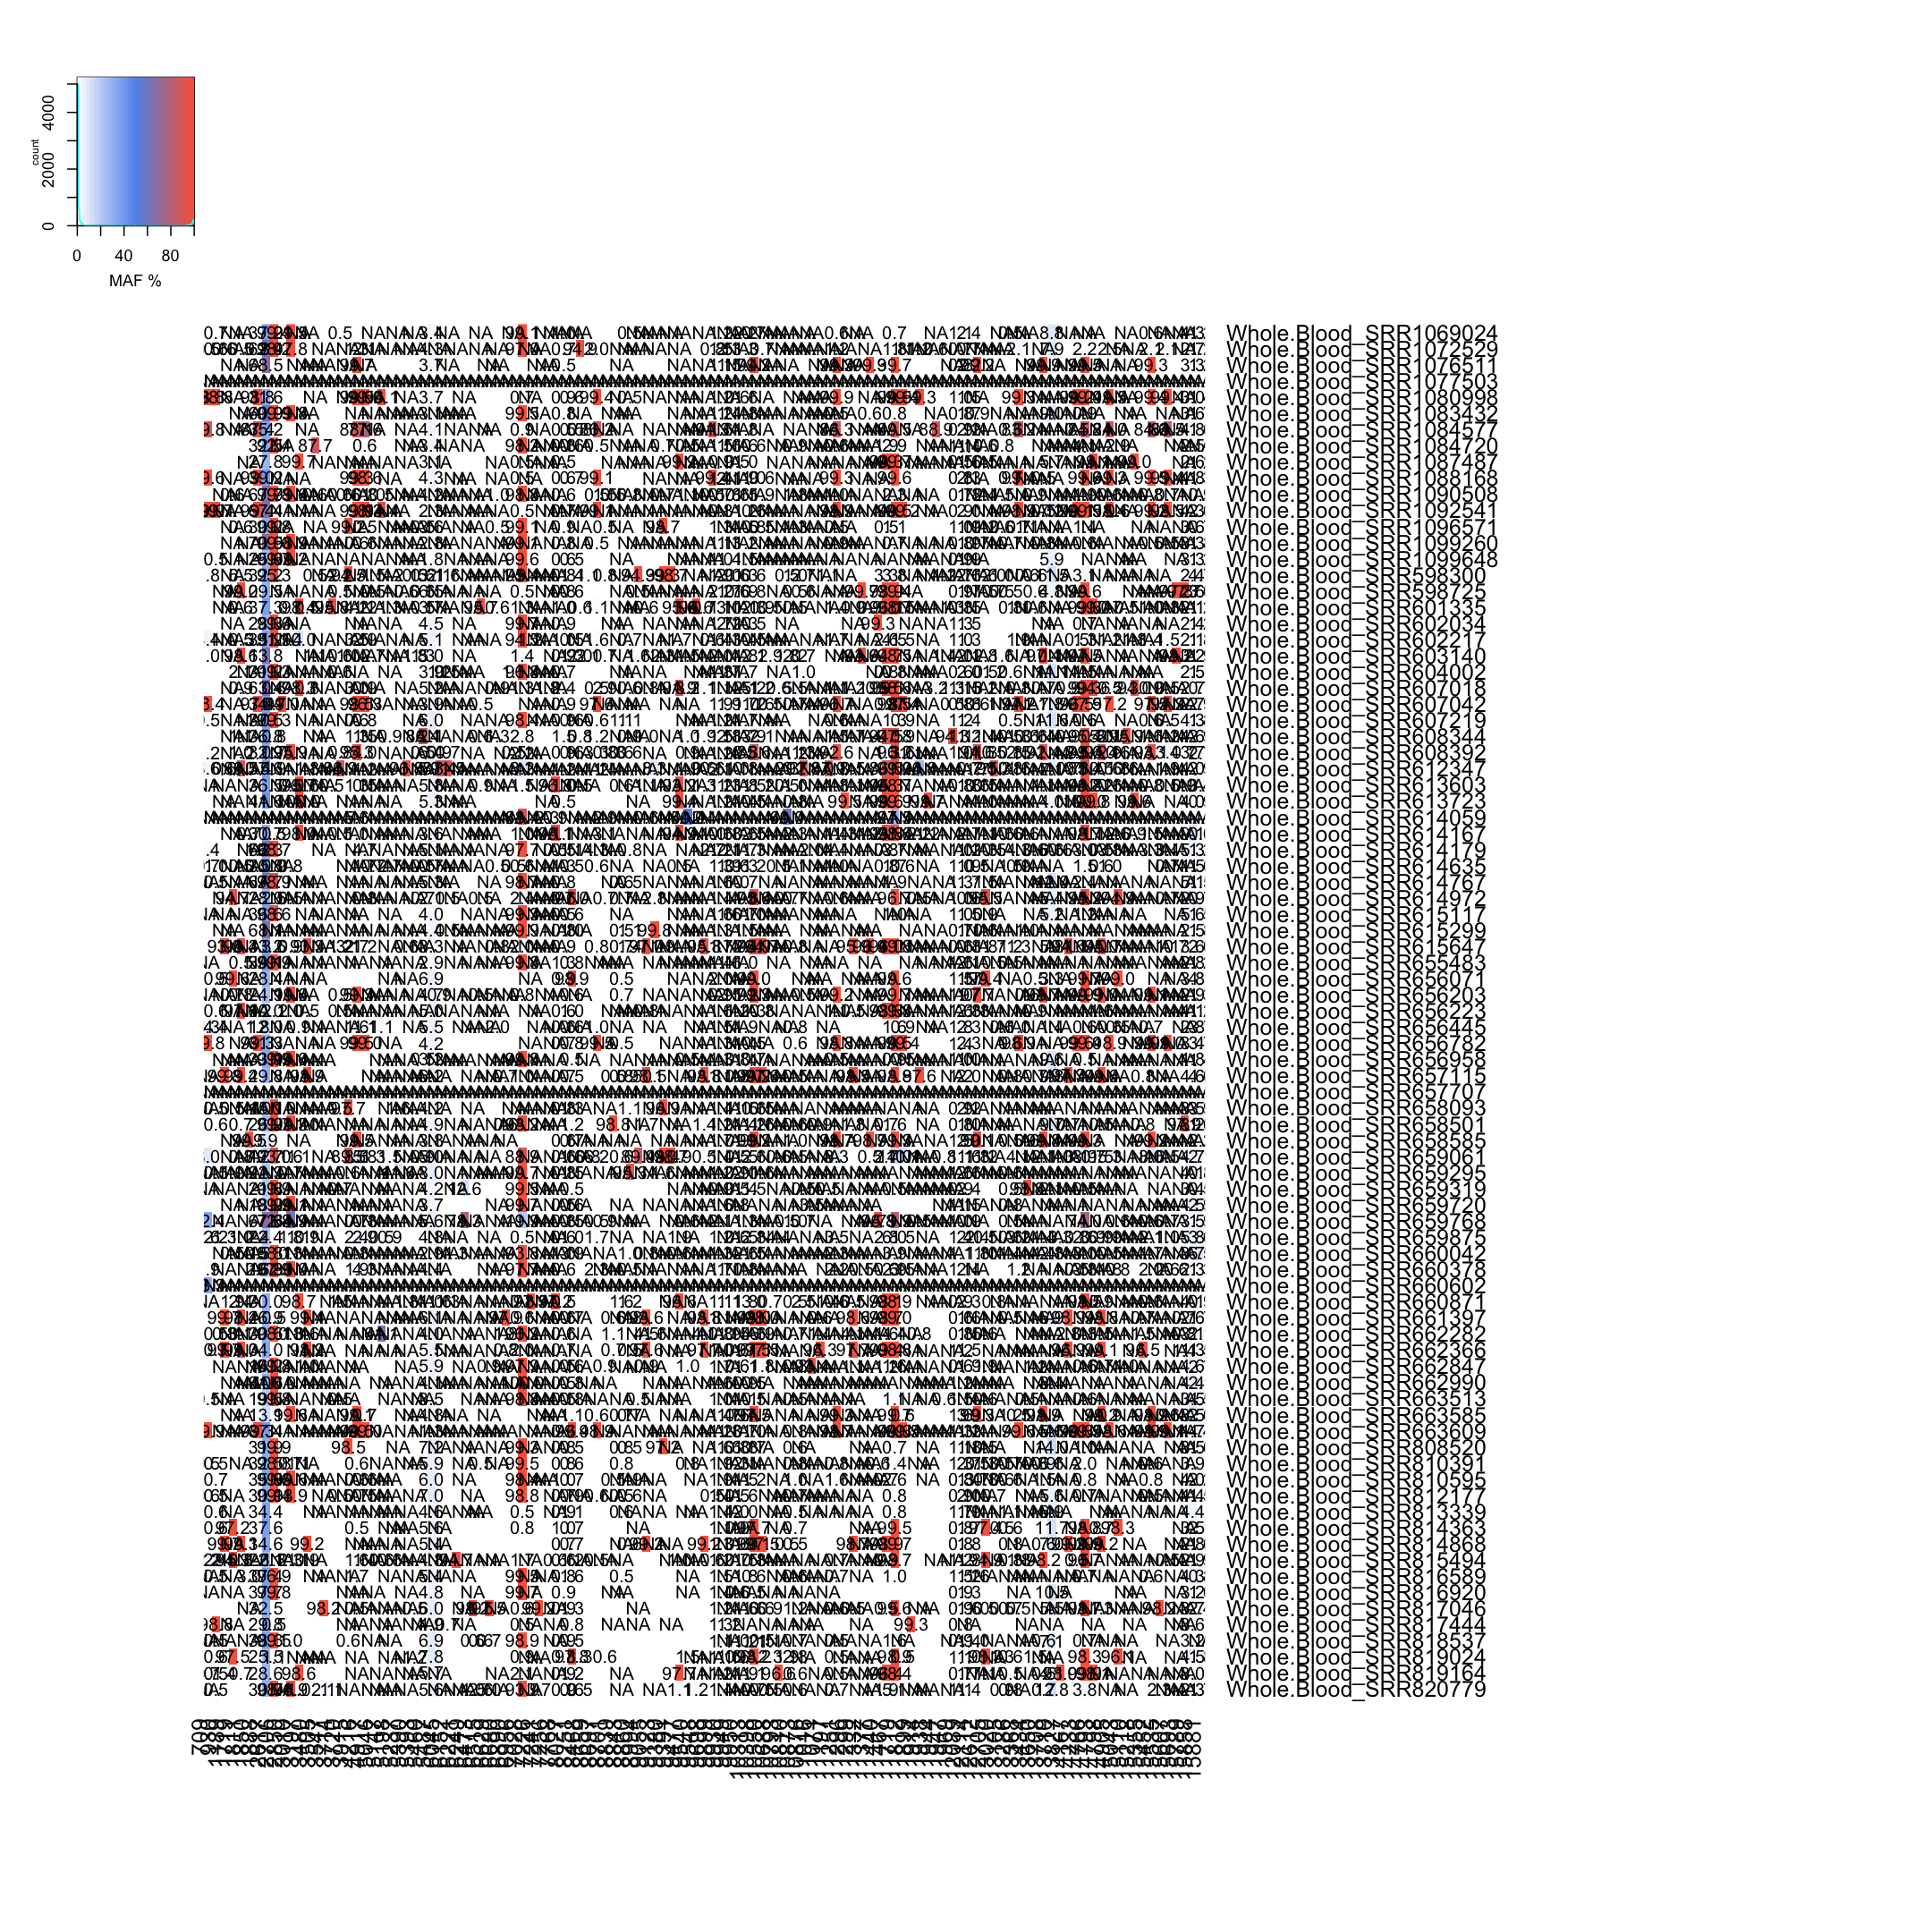

In [41]:
%%R -w 15 -h 15 -u in -r 144
par(oma=c(20,5,2,10))

select=c()
for (r in 1:nrow(tmpData)){
    
    nas = sum(is.na(tmpData[r,]))
    low = sum(tmpData[r,]<0.01*100,na.rm=TRUE)
    
    
#    if ( nas+low <= ncol(tmpData)/3 ) {
#        select = c(select,r)
#    }
#}

    #if ( (ncol(tmpData) - (nas+low)) >= (ncol(tmpData))*0.05  ) {
    if ( (ncol(tmpData) - (nas+low)) >= 2  ) {
        select = c(select,r)
    }
}



selectData=tmpData[select,]
selectData2 = apply(selectData,2, sprintf,fmt="%.1f")
selectData2[as.numeric(selectData2)<0.005*100] = ""



par(oma=c(5,0,2,30))

heatmap.2(t(selectData),
          dendrogram="none",
          Colv=F,
          Rowv=F,
          breaks=seq(0*100,1*100,0.01*100),
          trace="none",
          col=myPalette,
          keysize=0.75,
          key.title="",
          key.xlab="MAF %",
          key.ylab="count",
          key.par=list(cex.axis=1),
          margins=c(6,4),
          cexCol=1.25,
          cexRow=1.25,
          cellnote=t(selectData2),
          notecol='black',
          notecex=1,
          sepwidth=c(0.01,0.01),
          #rowsep=1:length(uniqPos),
          sepcol="gold",
          #colsep=14
)



In [42]:
%%R

bxData = t(selectData)[,seq(nrow(selectData),1)]

labs=c()
for (pos in colnames(bxData)){
    alleles = heatmap[heatmap$position==as.numeric(pos),2:3]
    lab = paste(alleles$major,pos,alleles$minor,sep="")
    labs=c(labs,lab)
}


In [43]:
%%R

# make NA cells with MAF < 1%
#back = bxData
bxData = back

#bxData[as.numeric(bxData)<0.01*100] = NA


Error in withVisible({ : object 'back' not found


/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'back' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 50 or more warnings (use warnings() to see the first 50)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


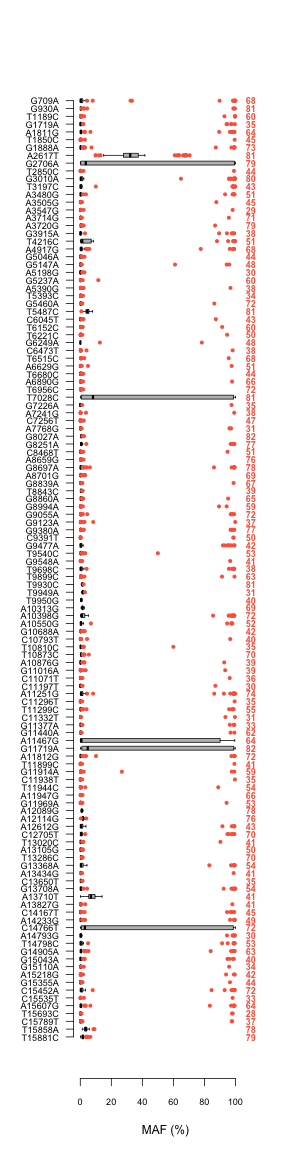

In [44]:
%%R -w 4 -h 16 -u in -r 72

par(oma=c(0,1,0,0))
CAXIS = 1 - (ncol(bxData)/500)

boxplot(bxData,las=1, frame=F, whisklty=1,col="grey",boxwex=0.5, xlab="MAF (%)",xlab="",
        cex.axis=CAXIS,pch=16,cex=0.75,outcol="tomato",ylim=c(0,110), names=labs,horizontal=T)


# Count the number of sites > 1% per site
notna = apply(bxData,2,FUN = function(x) sum(!(is.na(x))))

    
for (i in 1:length(notna)){
  text(110,i,lab=notna[i],cex=0.75,font=2,col="tomato")
}

### <i class="icon-exclamation" > We can add even more information to the quartets table. For instance, the impact of the alternative allele and the nucleotide change class </i>

In [45]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

In [46]:
def translate(sequence,gene):
    if len(str(sequence))%3!=0:
        add=3 - (len(str(sequence))%3)
    else:
        add=0

    if genedb[gene]["strand"]==1:
        modseq=str(sequence)+add*'A'        
    else:
        modseq=str(sequence.reverse_complement())+add*'A'

    try:
        translation=str(Seq(modseq,IUPAC.unambiguous_dna).translate(table=2,cds=True))
    except:
        translation=[]

    return translation

In [47]:
def evoImpact(quartet):
    het,major,minor = quartet
    pos  = int(het)-1
    gene = [g for g in genedb if genedb[g]['end']>=pos>=genedb[g]['start']]
    
    
    if gene:
        Gene=gene[0]

        if Gene in [feature.qualifiers['gene'][0] for feature in rCRS.features if feature.type=="CDS"]:

            majorseq = rCRS.seq.tomutable()
            minorseq = rCRS.seq.tomutable()
            majorseq[pos] = major
            minorseq[pos] = minor
            ref_seq = rCRS.seq[genedb[Gene]["start"]:genedb[Gene]["end"]]
            major_seq = majorseq[genedb[Gene]["start"]:genedb[Gene]["end"]]
            minor_seq = minorseq[genedb[Gene]["start"]:genedb[Gene]["end"]]

            if (translate(ref_seq,Gene)==translate(minor_seq,Gene)):
                ptimpact = "syn"
            else:
                ptimpact = "nonsyn"
        else:
            ptimpact = "-"
        
    else:
        ptimpact = "-"


    ntClass={'pu':['A','G'],'py':['C','T']}
    majorClass=[k for k,v in ntClass.iteritems() if major in v]
    minorClass=[k for k,v in ntClass.iteritems() if minor in v]
    if majorClass==minorClass:
        ntimpact='ts'
    else:
        ntimpact='tv'

    if gene:
        return pd.Series([ptimpact,genedb[gene[0]]['class'],ntimpact,gene[0]])
    else:
        return pd.Series([ptimpact,"noncoding",ntimpact,"noncoding"])

In [48]:
rCRS = SeqIO.read(open("/Users/boris/GoogleDrive/Genomes/rCRS.gb","r"), "genbank")
genedb = dict()
labs = ["class","start","end","strand"]
for feature in rCRS.features:
    if feature.type in ["rRNA","tRNA","CDS"]:
        ftype = feature.type
        name = feature.qualifiers['gene'][0]
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = int(feature.location.strand)
        genedb[name] = dict(zip(labs,[ftype,start,end,strand]))
genedb['D-loop1'] = dict(zip(labs,["Dloop",0,576,1]))
genedb['D-loop2'] = dict(zip(labs,["Dloop",16023,16569,1]))

In [49]:
heatmap[["ptchange","class","ntchange","gene"]] = heatmap[['position','major','minor']].apply(evoImpact,axis=1)

In [50]:
heatmap.head(2)

position major minor Whole Blood_SRR1069024 Whole Blood_SRR1072529  \
0     2617     A     T                0.37218                0.62366   
1     3552     T     G                     NA                     NA   

  Whole Blood_SRR1076511 Whole Blood_SRR1077503 Whole Blood_SRR1080998  \
0                0.68477                     NA                0.31622   
1                     NA                     NA                     NA   

  Whole Blood_SRR1083432 Whole Blood_SRR1084577  ...  Whole Blood_SRR817046  \
0                0.60888                0.35224  ...                0.32523   
1                0.00024                     NA  ...                     NA   

  Whole Blood_SRR817444 Whole Blood_SRR818537 Whole Blood_SRR819024  \
0               0.29771               0.38631               0.25544   
1                    NA               0.00016               0.00013   

  Whole Blood_SRR819164 Whole Blood_SRR820779 ptchange class ntchange  gene  
0               0.28569               0.30688        -  rRNA       tv  RNR2  
1               0.00027                    NA      syn   CDS       tv   ND1  

[2 rows x 92 columns]

In [51]:
def f(x):
    l = [i for i in x if i<0.01 or i=="NA"]
    #return(float(len(x) - len(l) - 7)>=(len(x)-7)*0.05)
    return(float(len(x) - len(l) - 7)>=2)

In [52]:
initial = heatmap.loc[heatmap.apply(f, axis=1), :]

initial.to_csv(annotated_out,sep="\t")

In [53]:
with open(bias) as b:
    first_line = b.readline()
    if "pos" in first_line.split('\t'):
        cycleBias = pd.read_table(bias)
    else:
        cycleBias = pd.read_table(bias,header=None)

In [54]:
%R -i cycleBias

In [55]:
%%R
clean = cycleBias$pos[apply(cycleBias[,c(2:ncol(cycleBias))],1,FUN=function(x) mean(x,na.rm=T)<=0.85)]
cleanbxData = bxData[,colnames(bxData) %in% clean]
cleanLabs = labs[colnames(bxData) %in% clean]

### Clean sites

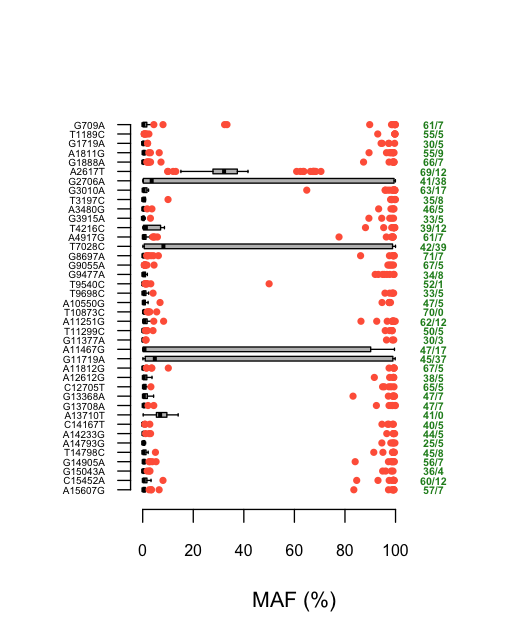

In [92]:
%%R -w 4 -h 5 -u in -r 128

par(oma=c(0,1,0,0))
CAXIS = 1 - (ncol(cleanbxData)/75)

boxplot(cleanbxData,las=1, frame=F, whisklty=1,col="grey",boxwex=0.5, xlab="MAF (%)",xlab="",
        cex.axis=CAXIS,pch=16,cex=0.75,outcol="tomato",ylim=c(0,120), names=cleanLabs,horizontal=T,xaxt="n")
axis(1,at=seq(0,100,20),cex.axis=0.75 )


# Count the number of sites > 1% per site
notna = apply(cleanbxData,2,FUN = function(x) sum(!(is.na(x))))
over = apply(cleanbxData,2,FUN = function(x) sum(!(is.na(x)) & (x)>=50))
    
for (i in 1:length(notna)){
  text(115,i,lab=paste(notna[i]-over[i],over[i],sep="/"),cex=0.5,font=2,col="forestgreen")
}

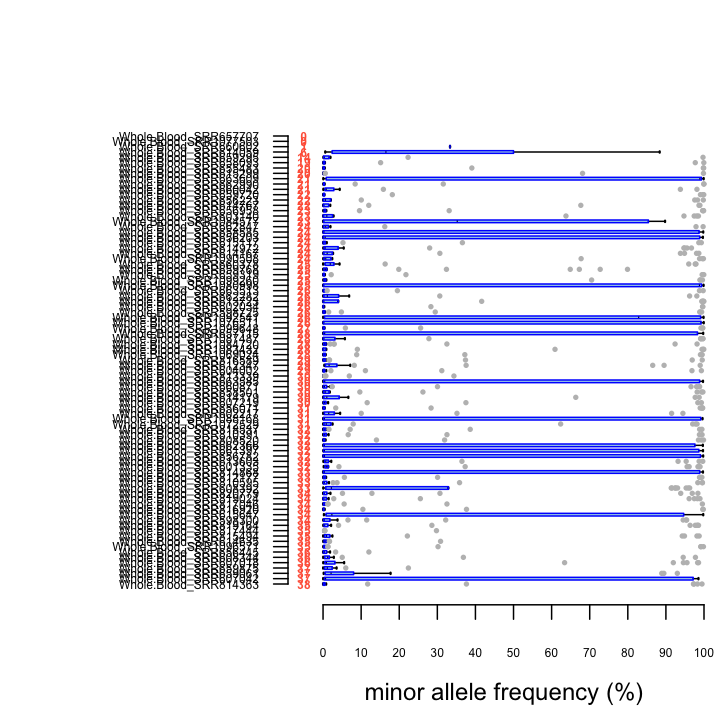

In [57]:
%%R -w 5 -h 5 -u in -r 144

# Minor allele distribution per individual, of unbiased sites, if the site >= 1%


newdata = t(cleanbxData/100)
nsites = apply(newdata, 2, FUN=function(x) sum(!(is.na(x))))
ordered = names(sort(nsites,decreasing=TRUE))

par(mar=c(4,10,4,0))
boxplot(
  newdata[,ordered],
  pch=16,cex=0.5,
  outcol="grey",outline=T,
  whisklty=1,whiskwd=1,
  staplelwd=1.5,
  boxwex=0.5,boxcol="blue",boxfill="lightblue",
  horizontal=T,cex.axis=0.5,las=2,
  frame=F,xaxt="n",ylim=c(-0.05,1),
    medlwd=0.75
  )

axis(1,at=seq(0,10,1)/10,lab=100*(seq(0,10,1)/10),cex.axis=0.5)
title(xlab="minor allele frequency (%)",line=2.5,cex.axis=0.75)


for (i in 1:length(nsites)){
  text(-0.05,i,lab=nsites[ordered][i],cex=0.5,font=2,col="tomato")
}
#mtext("Nsites:",side=3,line=-1,at=0,adj=1.25,col="tomato")

In [58]:
%%R
summary(nsites)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   24.00   29.00   27.47   33.00   38.00 


In [59]:
%%R -w 5 -h 5 -u in -r 72

par(oma=c(0,0,0,0))

h = hist(nsites, plot=FALSE,breaks=seq(0,25,5))

h$counts = h$counts/sum(h$counts)
plot(h,col="orange",lwd=2,border="tomato",cex.axis=1.5,cex.lab=1.5,ylim=c(0,1),main="",
     xlab="Number of sites per sample",ylab="Proportion of samples")
legend(0,1,legend=rbind(c("Min","1stQ","Med","Mean","3rdQ","Max"),summary(nsites)),bty="n",ncol=3,cex=1.3)


Error in hist.default(nsites, plot = FALSE, breaks = seq(0, 25, 5)) : 
  some 'x' not counted; maybe 'breaks' do not span range of 'x'


/Library/Python/2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in hist.default(nsites, plot = FALSE, breaks = seq(0, 25, 5)) : 
  some 'x' not counted; maybe 'breaks' do not span range of 'x'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [60]:
cycleBias["bias"] = cycleBias.iloc[:,1:].apply(np.mean,axis=1)

In [61]:
cycleBias = cycleBias.iloc[:,[0,-1]]
cycleBias.columns=["position","bias"]
cycleBias.head()

position      bias
0      2617  0.262875
1      2706  0.444500
2      3010  0.593000
3      4917  0.395606
4      7028  0.451481

In [62]:
initial.head()

position major minor Whole Blood_SRR1069024 Whole Blood_SRR1072529  \
0     2617     A     T                0.37218                0.62366   
3     2706     G     A                0.99377                0.98182   
4     3010     G     A                0.99508                0.97777   
6     4917     A     G                0.00412                0.02078   
7     7028     T     C                0.99067                0.97029   

  Whole Blood_SRR1076511 Whole Blood_SRR1077503 Whole Blood_SRR1080998  \
0                0.68477                     NA                0.31622   
3                0.00142                     NA                0.00257   
4                0.00128                     NA                0.00213   
6                     NA                     NA                0.99028   
7                0.00371                     NA                0.00686   

  Whole Blood_SRR1083432 Whole Blood_SRR1084577  ...  Whole Blood_SRR817046  \
0                0.60888                0.35224  ...                0.32523   
3                0.99943                0.00146  ...                0.00235   
4                0.99812                 0.0022  ...                0.00306   
6                0.00061                0.77648  ...                     NA   
7                0.99475                 0.0086  ...                 0.0061   

  Whole Blood_SRR817444 Whole Blood_SRR818537 Whole Blood_SRR819024  \
0               0.29771               0.38631               0.25544   
3               0.00467               0.99453               0.01103   
4               0.00393               0.01006               0.00182   
6               0.00164               0.00018               0.00218   
7               0.00474                0.9885               0.00899   

  Whole Blood_SRR819164 Whole Blood_SRR820779 ptchange class ntchange  gene  
0               0.28569               0.30688        -  rRNA       tv  RNR2  
3               0.00312               0.98399        -  rRNA       ts  RNR2  
4                0.0042               0.96917        -  rRNA       ts  RNR2  
6               0.00076               0.00029   nonsyn   CDS       ts   ND2  
7               0.02117               0.93889      syn   CDS       ts  COX1  

[5 rows x 92 columns]

In [63]:
tmp  = pd.merge(cycleBias, initial, on='position', how='inner')
clean = tmp[(tmp["bias"]<=0.85)]
clean.to_csv("clean_"+annotated_out,sep="\t")

In [64]:
%R -i clean

In [65]:
%%R
NCOL = ncol(clean)
table(clean[,c(NCOL-1,NCOL-2,NCOL-3)])

, , ptchange = -

        class
ntchange CDS rRNA
      ts   0    8
      tv   0    1

, , ptchange = nonsyn

        class
ntchange CDS rRNA
      ts   9    0
      tv   1    0

, , ptchange = syn

        class
ntchange CDS rRNA
      ts  20    0
      tv   1    0



### average number of high quality sites per individual

In [66]:
%%R
summary(apply(clean[,4:(NCOL-4)],2,FUN=function(x) sum(x>=0.01)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.00   17.00   21.00   21.83   25.00   40.00 


In [67]:
with open(kallisto) as kal:
    first_line = kal.readline()
    if first_line.startswith("#"):
        k = pd.read_table(kallisto)
    else:
        k = pd.read_table(kallisto,header=None)

In [68]:
k.columns = ["sample","gene","len","eff_len","est_counts","tpm"]

In [69]:
k.replace(to_replace=old,value=new2,inplace=True)

In [70]:
k.head()

sample   gene   len    eff_len  est_counts       tpm
0  Whole Blood_SRR1069024  ATP6    681   503.3660    22800.20   692.651
1  Whole Blood_SRR1069024  ATP8    207    61.1782     1365.65   341.351
2  Whole Blood_SRR1069024   CO1   1542  1364.3700    51571.30   578.011
3  Whole Blood_SRR1069024   CO2    684   506.3660    35621.80  1075.750
4  Whole Blood_SRR1069024   CO3    784   606.3660    26676.90   672.758

In [71]:
blood = dict()
for gene, tpm in k.loc[k[["sample"]].squeeze().str.contains("Blood"),["gene","tpm"]].itertuples(index=False):
    blood[gene] = tpm

In [72]:
#copy_number = pd.DataFrame(index=range(len(k[['sample']].drop_duplicates())), columns=['sample']+sorted(blood.keys()))
copy_number = pd.DataFrame(columns=['sample']+sorted(blood.keys()))

In [73]:
for group, dataframe in k.groupby('sample'):
    current = dict(dataframe[["gene","tpm"]].itertuples(index=False))
    cn = dict()
    for gene in blood:
        cn[gene] = current[gene]/blood[gene]
    cn['sample'] = group
    copy_number = copy_number.append(pd.Series(cn),ignore_index=True)
    
    

In [74]:
copy_number

sample     ATP6      ATP8       CO1       CO2       CO3   \
0   Whole Blood_SRR1069024  0.373630  0.177515  0.315743  0.399876  0.346797   
1   Whole Blood_SRR1072529  0.181001  0.183212  0.222946  0.188066  0.228416   
2   Whole Blood_SRR1076511  1.760907  1.104174  1.984317  1.380238  1.926987   
3   Whole Blood_SRR1077503  0.002595  0.000903  0.031057  0.005462  0.002820   
4   Whole Blood_SRR1080998  1.127508  1.126041  1.112458  0.898328  0.952864   
5   Whole Blood_SRR1083432  0.872211  0.597684  1.059853  1.051364  1.086478   
6   Whole Blood_SRR1084577  0.574197  0.648543  0.908469  0.606722  0.774594   
7   Whole Blood_SRR1084720  0.491922  0.454994  0.443675  0.531152  0.484117   
8   Whole Blood_SRR1087487  0.783768  0.585151  0.860202  0.857725  0.804683   
9   Whole Blood_SRR1088168  1.793542  1.197432  1.572412  1.485007  1.926466   
10  Whole Blood_SRR1090508  0.162673  0.150492  0.197248  0.159795  0.187327   
11  Whole Blood_SRR1092541  0.467829  0.440196  0.535255  0.570338  0.480963   
12  Whole Blood_SRR1096571  0.459341  0.347535  0.526698  0.465283  0.489622   
13  Whole Blood_SRR1099260  0.332546  0.321846  0.321383  0.380520  0.323958   
14  Whole Blood_SRR1099648  0.851206  0.740611  1.120379  0.965936  1.063003   
15   Whole Blood_SRR598300  0.935690  1.129744  1.040232  0.720940  0.793687   
16   Whole Blood_SRR598725  1.055679  0.974674  1.633199  1.027883  1.264083   
17   Whole Blood_SRR601335  0.334463  0.333481  0.363974  0.267790  0.290965   
18   Whole Blood_SRR602034  1.292323  1.171898  1.859355  1.056988  1.196926   
19   Whole Blood_SRR602217  0.834371  0.956254  0.722501  0.633954  0.672064   
20   Whole Blood_SRR603140  1.024344  0.919602  1.263340  1.368060  0.886702   
21   Whole Blood_SRR604002  0.564547  0.507731  0.480877  0.538315  0.436926   
22   Whole Blood_SRR607018  0.374909  0.390682  0.392550  0.348150  0.316146   
23   Whole Blood_SRR607042  0.490644  0.486417  0.339250  0.479829  0.640274   
24   Whole Blood_SRR607219  1.304309  1.543361  1.264416  1.161526  1.149908   
25   Whole Blood_SRR608344  0.438997  0.465128  0.415114  0.417893  0.417701   
26   Whole Blood_SRR608392  0.928074  1.137493  0.882069  0.701053  0.809539   
27   Whole Blood_SRR612347  2.342171  3.476494  2.530153  1.918166  2.348922   
28   Whole Blood_SRR613603  1.220262  1.260211  0.925474  1.076448  0.667244   
29   Whole Blood_SRR613723  3.223978  2.368509  1.392748  1.704822  2.566327   
..                     ...       ...       ...       ...       ...       ...   
55   Whole Blood_SRR659768  0.914038  1.076451  1.260362  0.722338  0.906589   
56   Whole Blood_SRR659875  0.749067  0.591058  0.782710  0.654406  0.876340   
57   Whole Blood_SRR660042  1.682804  2.305402  1.974927  1.546221  2.058513   
58   Whole Blood_SRR660378  1.826819  2.130925  1.695702  1.425967  1.697828   
59   Whole Blood_SRR660602  0.008113  0.002174  0.060187  0.016007  0.009941   
60   Whole Blood_SRR660871  1.486746  1.087673  2.398833  1.697016  1.824848   
61   Whole Blood_SRR661397  1.042539  1.371608  1.304915  0.968192  1.097148   
62   Whole Blood_SRR662282  1.371111  1.960633  1.332763  1.338048  1.294156   
63   Whole Blood_SRR662366  0.986067  1.435947  1.158573  1.042502  1.026728   
64   Whole Blood_SRR662847  0.927820  1.197739  0.913320  0.925597  0.779310   
65   Whole Blood_SRR662990  1.131964  0.830224  1.444795  1.253263  1.109654   
66   Whole Blood_SRR663513  0.432531  0.397536  0.618549  0.535743  0.531826   
67   Whole Blood_SRR663585  0.875291  0.491474  1.050010  0.868546  0.997196   
68   Whole Blood_SRR663609  0.436179  0.415745  0.496331  0.415700  0.379858   
69   Whole Blood_SRR808520  0.518066  0.501047  0.554773  0.681597  0.505240   
70   Whole Blood_SRR810391  0.679762  0.649006  0.878649  0.852859  0.519202   
71   Whole Blood_SRR810595  0.434869  0.476979  0.542099  0.461536  0.531924   
72   Whole Blood_SRR812177  0.367366  0.337132  0.411178  0.402102  0.407766   
73   Whole Blood_SRR

In [75]:
%R -i copy_number

In [76]:
%%R
copy_number = do.call(data.frame,lapply(copy_number, function(x) replace(x, is.infinite(x),NA)))

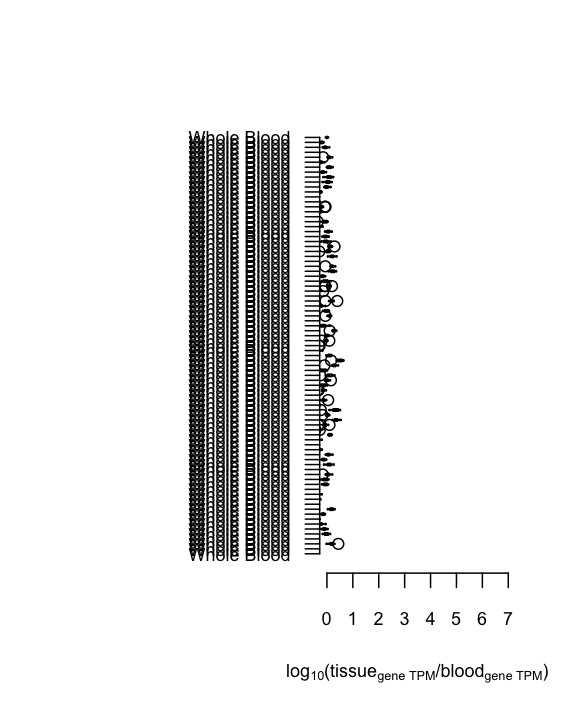

In [77]:
%%R -w 4 -h 5 -u in -r 144

par(oma=c(0,7,0,0))

Names = c()
for (s in copy_number$sample){
    
    id = unlist(strsplit(s,split="_"))[1]
    Names = c(Names,id)
    
}


boxplot(t(log10(copy_number[,2:14])),boxwex=0.5,
       whisklty=1, axes=F,ylim=c(0,7),col="azure3",whisklwd=1.5,horizontal=T)
axis(1,at=0:7,las=1,cex.axis=0.75)
axis(2, at=1:nrow(copy_number),lab=Names,las=2,cex.axis=0.75)
title(xlab=expression(paste( "log"[10], "(tissue"["gene TPM"],"/blood"["gene TPM"],  ")")),cex.lab=0.75)




In [78]:
k[(k.gene == "RNR2 ")]

sample   gene   len  eff_len   est_counts          tpm
14    Whole Blood_SRR1069024  RNR2   1559  1381.37   59006.0000   653.200000
51    Whole Blood_SRR1072529  RNR2   1559  1364.57   58084.8000   479.509000
88    Whole Blood_SRR1076511  RNR2   1559  1361.46  224562.0000  3754.540000
125   Whole Blood_SRR1077503  RNR2   1559  1367.36      12.0560     0.130788
162   Whole Blood_SRR1080998  RNR2   1559  1369.16   69054.7000   912.534000
199   Whole Blood_SRR1083432  RNR2   1559  1351.09  163888.0000  3735.860000
236   Whole Blood_SRR1084577  RNR2   1559  1368.79  116610.0000  1393.480000
273   Whole Blood_SRR1084720  RNR2   1559  1365.00   86020.9000  1271.690000
310   Whole Blood_SRR1087487  RNR2   1559  1367.01   96678.9000  2221.620000
347   Whole Blood_SRR1088168  RNR2   1559  1362.75  150964.0000  3855.700000
384   Whole Blood_SRR1090508  RNR2   1559  1375.96   68769.9000   555.046000
421   Whole Blood_SRR1092541  RNR2   1559  1376.80   69979.9000  1805.660000
458   Whole Blood_SRR1096571  RNR2   1559  1387.45   28819.0000   468.525000
495   Whole Blood_SRR1099260  RNR2   1559  1390.44   33511.0000   603.853000
532   Whole Blood_SRR1099648  RNR2   1559  1370.61   59227.9000  1196.970000
569    Whole Blood_SRR598300  RNR2   1559  1396.89   94265.7000  1335.020000
606    Whole Blood_SRR598725  RNR2   1559  1397.51  128936.0000  3147.300000
643    Whole Blood_SRR601335  RNR2   1559  1403.07   75306.3000  1156.450000
680    Whole Blood_SRR602034  RNR2   1559  1401.06  187153.0000  3004.090000
717    Whole Blood_SRR602217  RNR2   1559  1397.70  102843.0000  1155.560000
754    Whole Blood_SRR603140  RNR2   1559  1395.98  331004.0000  5617.620000
791    Whole Blood_SRR604002  RNR2   1559  1403.05  130846.0000  1149.840000
828    Whole Blood_SRR607018  RNR2   1559  1396.61  121172.0000  1296.490000
865    Whole Blood_SRR607042  RNR2   1559  1401.99  103784.0000  1234.930000
902    Whole Blood_SRR607219  RNR2   1559  1391.88  207487.0000  2840.350000
939    Whole Blood_SRR608344  RNR2   1559  1396.22  115515.0000  1732.630000
976    Whole Blood_SRR608392  RNR2   1559  1401.72  221039.0000  2564.680000
1013   Whole Blood_SRR612347  RNR2   1559  1400.48   18356.5000  3487.090000
1050   Whole Blood_SRR613603  RNR2   1559  1356.27   26633.7000  1722.740000
1087   Whole Blood_SRR613723  RNR2   1559  1355.43  167500.0000  4309.930000
...                      ...    ...   ...      ...          ...          ...
2049   Whole Blood_SRR659768  RNR2   1559  1399.37   49811.5000  1911.790000
2086   Whole Blood_SRR659875  RNR2   1559  1309.37  143732.0000  1342.000000
2123   Whole Blood_SRR660042  RNR2   1559  1312.69   56666.8000  2811.580000
2160   Whole Blood_SRR660378  RNR2   1559  1379.96   96271.9000  2210.250000
2197   Whole Blood_SRR660602  RNR2   1559  1357.10      52.8425     0.800145
2234   Whole Blood_SRR660871  RNR2   1559  1287.78   90959.4000  3932.440000
2271   Whole Blood_SRR661397  RNR2   1559  1361.85   55029.2000  1146.520000
2308   Whole Blood_SRR662282  RNR2   1559  1381.60   53933.4000  1639.770000
2345   Whole Blood_SRR662366  RNR2   1559  1367.37   98097.4000  2344.610000
2382   Whole Blood_SRR662847  RNR2   1559  1375.80  116025.0000  1842.230000
2419   Whole Blood_SRR662990  RNR2   1559  1331.93  182162.0000  3708.840000
2456   Whole Blood_SRR663513  RNR2   1559  1323.00  113735.0000  1255.740000
2493   Whole Blood_SRR663585  RNR2   1559  1253.51  345205.0000  2784.900000
2530   Whole Blood_SRR663609  RNR2   1559  1346.04   70322.6000  1051.120000
2567   Whole Blood_SRR808520  RNR2   1559  1367.16  177980.0000  1701.710000
2604   Whole Blood_SRR810391  RNR2   1559  1370.36  140255.0000  2608.780000
2641   Whole Blood_SRR810595  RNR2   1559  1374.06  115772.0000  1360.710000
2678   Whole Blood_SRR812177  RNR2   1559  1360.25   74109.8000   983.838000
2715   Whole Blood_SRR813339  RNR2   1559  1378.64  116335.0000  1590.360000
2752   Whole Blood_SRR814363  RNR2   1559  1375.66  147700.0000  1548.550000
2789   Whole Blood

In [79]:
a = heatmap[(heatmap.position==2617)].transpose()
a["sample"] = a.index
a.columns = ["maf","sample"]

In [80]:
rnr2 = k[(k.gene == "RNR2 ")].join(a,on="sample",lsuffix="L",rsuffix="R")

In [81]:
%R -i rnr2

In [82]:
rnr2

sampleL   gene   len  eff_len   est_counts          tpm  \
14    Whole Blood_SRR1069024  RNR2   1559  1381.37   59006.0000   653.200000   
51    Whole Blood_SRR1072529  RNR2   1559  1364.57   58084.8000   479.509000   
88    Whole Blood_SRR1076511  RNR2   1559  1361.46  224562.0000  3754.540000   
125   Whole Blood_SRR1077503  RNR2   1559  1367.36      12.0560     0.130788   
162   Whole Blood_SRR1080998  RNR2   1559  1369.16   69054.7000   912.534000   
199   Whole Blood_SRR1083432  RNR2   1559  1351.09  163888.0000  3735.860000   
236   Whole Blood_SRR1084577  RNR2   1559  1368.79  116610.0000  1393.480000   
273   Whole Blood_SRR1084720  RNR2   1559  1365.00   86020.9000  1271.690000   
310   Whole Blood_SRR1087487  RNR2   1559  1367.01   96678.9000  2221.620000   
347   Whole Blood_SRR1088168  RNR2   1559  1362.75  150964.0000  3855.700000   
384   Whole Blood_SRR1090508  RNR2   1559  1375.96   68769.9000   555.046000   
421   Whole Blood_SRR1092541  RNR2   1559  1376.80   69979.9000  1805.660000   
458   Whole Blood_SRR1096571  RNR2   1559  1387.45   28819.0000   468.525000   
495   Whole Blood_SRR1099260  RNR2   1559  1390.44   33511.0000   603.853000   
532   Whole Blood_SRR1099648  RNR2   1559  1370.61   59227.9000  1196.970000   
569    Whole Blood_SRR598300  RNR2   1559  1396.89   94265.7000  1335.020000   
606    Whole Blood_SRR598725  RNR2   1559  1397.51  128936.0000  3147.300000   
643    Whole Blood_SRR601335  RNR2   1559  1403.07   75306.3000  1156.450000   
680    Whole Blood_SRR602034  RNR2   1559  1401.06  187153.0000  3004.090000   
717    Whole Blood_SRR602217  RNR2   1559  1397.70  102843.0000  1155.560000   
754    Whole Blood_SRR603140  RNR2   1559  1395.98  331004.0000  5617.620000   
791    Whole Blood_SRR604002  RNR2   1559  1403.05  130846.0000  1149.840000   
828    Whole Blood_SRR607018  RNR2   1559  1396.61  121172.0000  1296.490000   
865    Whole Blood_SRR607042  RNR2   1559  1401.99  103784.0000  1234.930000   
902    Whole Blood_SRR607219  RNR2   1559  1391.88  207487.0000  2840.350000   
939    Whole Blood_SRR608344  RNR2   1559  1396.22  115515.0000  1732.630000   
976    Whole Blood_SRR608392  RNR2   1559  1401.72  221039.0000  2564.680000   
1013   Whole Blood_SRR612347  RNR2   1559  1400.48   18356.5000  3487.090000   
1050   Whole Blood_SRR613603  RNR2   1559  1356.27   26633.7000  1722.740000   
1087   Whole Blood_SRR613723  RNR2   1559  1355.43  167500.0000  4309.930000   
...                      ...    ...   ...      ...          ...          ...   
2049   Whole Blood_SRR659768  RNR2   1559  1399.37   49811.5000  1911.790000   
2086   Whole Blood_SRR659875  RNR2   1559  1309.37  143732.0000  1342.000000   
2123   Whole Blood_SRR660042  RNR2   1559  1312.69   56666.8000  2811.580000   
2160   Whole Blood_SRR660378  RNR2   1559  1379.96   96271.9000  2210.250000   
2197   Whole Blood_SRR660602  RNR2   1559  1357.10      52.8425     0.800145   
2234   Whole Blood_SRR660871  RNR2   1559  1287.78   90959.4000  3932.440000   
2271   Whole Blood_SRR661397  RNR2   1559  1361.85   55029.2000  1146.520000   
2308   Whole Blood_SRR662282  RNR2   1559  1381.60   53933.4000  1639.770000   
2345   Whole Blood_SRR662366  RNR2   1559  1367.37   98097.4000  2344.610000   
2382   Whole Blood_SRR662847  RNR2   1559  1375.80  116025.0000  1842.230000   
2419   Whole Blood_SRR662990  RNR2   1559  1331.93  182162.0000  3708.840000   
2456   Whole Blood_SRR663513  RNR2   1559  1323.00  113735.0000  1255.740000   
2493   Whole Blood_SRR663585  RNR2   1559  1253.51  345205.0000  2784.900000   
2530   Whole Blood_SRR663609  RNR2   1559  1346.04   70322.6000  1051.120000   
2567   Whole Blood_SRR808520  RNR2   1559  1367.16  177980.0000  1701.710000   
2604   Whole Blood_SRR810391  RNR2   1559  1370.36  140255.0000  2608.780000   
2641   Whole Blood_SRR810595  RNR2   1559  1374.06  115772.0000  1360.710000   
2678   Whole Blood_SRR812177  RNR2   1559  1360.25   74109.8000   983.838000   
2715   Whole Blood_SR

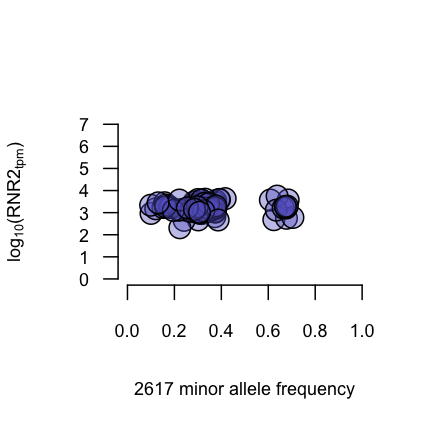

In [83]:
%%R -w 3 -h 3 -u in -r 144

rnr2$maf = as.numeric(as.character(rnr2$maf))

plot(rnr2$maf,log10(rnr2$tpm),cex.axis=0.75,frame=F,pch=21,col="black",bg=rgb(100,100,200,100,maxColorValue=255),
    xlim=c(0,1),cex.lab=0.75,xlab="2617 minor allele frequency",ylab=expression(paste("log"[10], "(RNR2"["tpm"],")")),
    ylim=c(0,7),yaxt="n",cex=2)
axis(2,at=0:7,las=2,cex.axis=0.75)

In [84]:
! ipython nbconvert dissertation_heteroplasmies_final.ipynb

[NbConvertApp] Converting notebook dissertation_heteroplasmies_final.ipynb to html
[NbConvertApp] Writing 347541 bytes to dissertation_heteroplasmies_final.html


In [85]:
! mv dissertation_heteroplasmies_final.html {sampleName}.html

In [86]:
% notebook -e {sampleName}.ipynb